In [1]:
from IPython.core.display import HTML
#css_file = '/Users/Luis/numerical-mooc/styles/numericalmoocstyle.css'
css_file = './numericalmoocstyle.css'
HTML(open(css_file, "r").read())


In [2]:
import numba
from numba import jit

##### This notebook uses a cell-centered grid approach to solve the Taylor-Green Vortex. The algorithm uses a RK3 fractional step method



Integrate the Navier-Stokes equations numerically between t = 0 and t = 2 using (1–3) as initial conditions and periodic boundary conditions over the domain 0 ≤ x ≤ 2π, 0 ≤ y ≤ 2π. Use either the 3rd-order Runge- Kutta explicit time advancement scheme or the Adams-Bashforth scheme. Use a staggered grid (Fig. 2) and compare your results to the analytical solution. To apply the boundary conditions, define a row of ghost points around your grid. Demonstrate the spatial and temporal accuracy of your solver.

The Taylor-Green vortex is an exact solution of the Navier-Stokes equations that, for $\nu$ = 1, is given by

\begin{align}
u &= − e^{−2t} \ cos(x) \ sin(y) \\
v &= e^{−2t} \ sin(x) \ cos(y) \\
\textbf{P} &= − \frac{e^{−4t}}{4} \ \bigg( cos(2x) \ + \ cos(2y) \bigg) 
\end{align}

where 

$
\textbf{P} = \frac{P}{\rho}
$

In [3]:
from math import pi
import numpy
#
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot, cm
#%matplotlib notebook
%matplotlib inline
#
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [4]:
# Parameters
# nx = [26, 51, 101, 151, 201]
# ny = [26,51, 101, 151, 201]
#
nx = [26, 51, 76, 101, 151, 201]
ny = [26, 51, 76, 101, 151, 201]
#
#Domain Size
xmin = 0.
xmax = 2.0*numpy.pi
ymin = 0.
ymax = 2.0*numpy.pi
#L2 Target
l2_target = 1e-8

In [5]:
def domain (numxg, numyg, x_min, x_max, y_min, y_max):
    #
    ngrid = numpy.size(numxg)
    # define sizes
    delxg = [] #spacing
    delyg = []
    #
    Xbg = []
    Ybg = []
    #
    Xbg2 = []
    Ybg2 = []
    #
    Xbg3 = []
    Ybg3 = []
    #
    Xcg = []
    Ycg = []
    #
    xbg = []
    xcg = []
    #
    ybg = []
    ycg = []
    #
    xbg2 = []
    ybg2 = []
    #
    xbg3 = []
    ybg3 = []
    #
    for i in range(ngrid):
        #fill array of grid nodes
        nx_k = numxg[i]
        ny_k = numyg[i]
        #grid spacing
        delx_k = (x_max-x_min)/(nx_k-1)
        dely_k = (y_max-y_min)/(ny_k-1)
        #
        delxg.append(delx_k)
        delyg.append(dely_k)
        #
        #general grid, nodes on corners of each cell
        xb_k = numpy.linspace(x_min, x_max, nx_k)
        yb_k = numpy.linspace(y_min, y_max, ny_k)
        #
        #needed for velocity calculatons
        # x-velocity grid
        xb2_k = xb_k.copy()
        yb2_k = yb_k[:-1]+(dely_k*.5) 
        #y-velocity grid
        xb3_k = xb_k[:-1]+(delx_k*.5) 
        yb3_k = yb_k.copy()
        #
        #needed for pressure
        #
        xc_k = xb_k[:-1]+(delx_k*.5)      
        yc_k = yb_k[:-1]+(dely_k*.5)  
        #
        xbg.append(xb_k)
        xbg2.append(xb2_k)
        xbg3.append(xb3_k)
        xcg.append(xc_k)
        #
        ybg.append(yb_k)
        ybg2.append(yb2_k)
        ybg3.append(yb3_k)
        ycg.append(yc_k)
        #
        Xb_k,Yb_k = numpy.meshgrid(xb_k,yb_k)
        Xb2_k,Yb2_k = numpy.meshgrid(xb2_k,yb2_k)
        Xb3_k, Yb3_k = numpy.meshgrid(xb3_k,yb3_k)
        Xc_k,Yc_k = numpy.meshgrid(xc_k,yc_k)
        #
        Xbg.append(Xb_k)
        Xbg2.append(Xb2_k)
        Xbg3.append(Xb3_k)
        Xcg.append(Xc_k)
        #
        Ybg.append(Yb_k)
        Ybg2.append(Yb2_k)
        Ybg3.append(Yb3_k)
        Ycg.append(Yc_k)
        #
    return xbg,ybg,xcg,ycg, Xbg, Ybg, Xcg, Ycg, delxg, delyg,\
            xbg2, ybg2, Xbg2, Ybg2, xbg3, ybg3, Xbg3, Ybg3
        
    
    

In [6]:
xb,yb,xc,yc,Xb,Yb,Xc,Yc,dx,dy,xb2, yb2, Xb2, Yb2, xb3, yb3, Xb3, Yb3 =\
    domain (nx, ny, xmin, xmax, ymin, ymax)

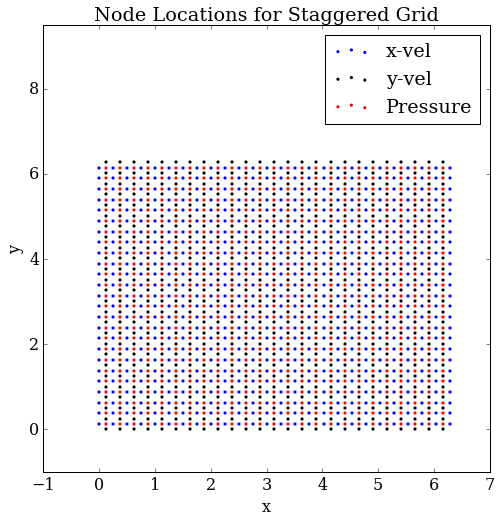

In [7]:
#
fig = pyplot.figure(figsize=(8,8))
pyplot.title('Node Locations for Staggered Grid')
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.ylim(-1,9.5)
pyplot.scatter(Xb2[0], Yb2[0],\
                   s=10, color='b', marker='o', linewidth=0)
pyplot.scatter(Xb3[0], Yb3[0],\
                   s=10, color='k', marker='o', linewidth=0)
pyplot.scatter(Xc[0], Yc[0],\
                   s=10, color='r', marker='o', linewidth=0)
pyplot.legend(['x-vel','y-vel','Pressure'])
pyplot.savefig('staggered_grid_final.png');

In [8]:
def L2_error(p_new, p_old):
    '''This function computes the L2 norm of the error for convergence

    Parameters:
    ----------
    p_new: new computed potential in flow field
    p_old: previous flow field potential
    
    Returns:
    ----------
    error!
    
    1:-1,1:-1
    '''
    
    return numpy.sqrt(numpy.sum((p_new[1:-1,1:-1] - p_old[1:-1,1:-1])**2)\
                      /numpy.sum(p_old[1:-1,1:-1]**2))

In [9]:
def plot_error_grid_refine(err1,nv, string_title):
    pyplot.figure(figsize=(8,8))
    
    pyplot.grid(True)
    pyplot.xlabel(r'$n_{cells}$', fontsize=18)
    pyplot.ylabel(r'$L_2$-norm of the error', fontsize=18)
    pyplot.title(string_title)
    #
    pyplot.loglog(nv, err1, color='k', ls='--', lw=2, marker='o')
    pyplot.axis('equal');

In [10]:
def plot_error_time_refine(err1,nv, string_title):
    pyplot.figure(figsize=(8,8))
    
    pyplot.grid(True)
    pyplot.xlabel(r'$dt (seconds)$', fontsize=18)
    pyplot.ylabel(r'$L_2$-norm of the error', fontsize=18)
    pyplot.title(string_title)
    #
    pyplot.plot(nv, err1, color='k', ls='--', lw=2, marker='o')
    pyplot.axis('equal');

In [11]:
def plot_2D(xp, yp, p_sol):
    '''This function creates 2D plot for solution

    Parameters:
    ----------
    xp: array of x grid points
    yp: array of y grid points
    p_sol: 2D array of calculated solution
    
    Returns:
    ----------
    2D plot
    ''' 
    fig = pyplot.figure(figsize=(8,5))

    pyplot.contour(xp,yp,p_sol)
    pyplot.xlabel('$x$')
    pyplot.ylabel('$y$')
    pyplot.colorbar();

In [12]:
def plot_3D(xp, yp, p_sol):
    '''This function creates 3D plot for solution

    Parameters:
    ----------
    xp: array of x grid points
    yp: array of y grid points
    p_sol: 2D array of calculated solution
    
    Returns:
    ----------
    3D plot of result
    '''
    fig = pyplot.figure(figsize=(11,7), dpi=100)
    ax = fig.gca(projection='3d')
    XP,YP = numpy.meshgrid(xp,yp)
    surf = ax.plot_surface(XP,YP,p_sol[:], rstride=1, cstride=1, cmap=cm.cool,\
                           linewidth=0, antialiased=True)

    #ax.set_xlim(0,1)
    #ax.set_ylim(0,1)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')
    ax.view_init(30,45)

In [13]:
def vel_analytical(X1,Y1, X2, Y2, t):
    '''This function calculates the analytical solution to the
    x- and y-components of velocity.

    Parameters:
    ----------
    XP: 2D array of floats x-position of mesh
    YP: 2D array of floats y-position of mesh
    
    Returns:
    ----------
    x and y components of velocity
    '''
    Ux = - numpy.exp(-2.*t) * numpy.cos(X1) * numpy.sin(Y1)
    Uy = numpy.exp(-2.*t) * numpy.sin(X2) * numpy.cos(Y2)
    #
    return Ux,Uy

In [14]:
def P_analytical(XP,YP, t):
    '''This function calculates the analytical solution to the Pressure field
    Note that this pressure is P/rho

    Parameters:
    ----------
    XP: 2D array x-position of mesh
    YP: 2D array y-position of mesh
    
    Returns:
    ----------
    analytical solution to Pressure (P/$\rho$)
    '''
    P_analytical = - 0.25*numpy.exp(-4.*t) * ( numpy.cos(2*XP) + numpy.cos(2*YP) )
    #
    return P_analytical

In [15]:
def pressure_ghost_cells(pv,x3,y3):
    ''' creates ghost cells for pressure calculation
    '''
    a = numpy.size(y3)+2
    b = numpy.size(x3)+2
    #
    pg = numpy.zeros((a,b), dtype=float)
    #
    pg[1:-1,1:-1] = pv.copy()
    #
    #x-direction periodicty:
    pg[1:-1,0] = pv[:,-1]
    pg[1:-1,-1] = pv[:,0]
    #y-direction periodicity:
    pg[0,1:-1] = pv[-1,:]
    pg[-1,1:-1] = pv[0,:]
    #
    return pg

In [16]:
def velocity_divergence(u,v,pv,delx,dely):
    ''' Check if velocity field is divergence free
    '''
    Vdiv = numpy.zeros_like(pv[:,:])
    #
    Vdiv[:,:] = (0.25/delx)*((u[1:-1,3:]+u[1:-1,2:-1])-2*(u[1:-1,2:-1]+u[1:-1,1:-2])+\
                             (u[1:-1,1:-2]+u[1:-1,:-3])) +\
                (0.25/dely)*((v[3:,1:-1]+v[2:-1,1:-1])-2*(v[2:-1,1:-1]+v[1:-2,1:-1])+\
                             (v[1:-2,1:-1]+v[:-3,1:-1]))
    #
    return Vdiv

In [17]:
def velocity_boundaries(u,v,t,X1,Y1,X2,Y2):
    ''' Updates velocities on the boundaries based on analytical function
    '''
    ubc = u.copy() 
    vbc = v.copy() 
    #
    ubc[:,0]  = - numpy.exp(-2.*t) * numpy.cos(X1[:,0])  * numpy.sin(Y1[:,0])
    ubc[:,-1] = - numpy.exp(-2.*t) * numpy.cos(X1[:,-1]) * numpy.sin(Y1[:,-1])
    ubc[0,:]  = - numpy.exp(-2.*t) * numpy.cos(X1[0,:])  * numpy.sin(Y1[0,:])
    ubc[-1,:] = - numpy.exp(-2.*t) * numpy.cos(X1[-1,:]) * numpy.sin(Y1[-1,:])
    #
    vbc[:,0]  = numpy.exp(-2.*t) * numpy.sin(X2[:,0])  * numpy.cos(Y2[:,0])
    vbc[:,-1] = numpy.exp(-2.*t) * numpy.sin(X2[:,-1]) * numpy.cos(Y2[:,-1])
    vbc[0,:]  = numpy.exp(-2.*t) * numpy.sin(X2[0,:])  * numpy.cos(Y2[0,:])
    vbc[-1,:] = numpy.exp(-2.*t) * numpy.sin(X2[-1,:]) * numpy.cos(Y2[-1,:])
    
    return ubc,vbc

In [18]:
def velocity_ghost_cells(u,v,x1,y1,x2,y2):
    ''' includes ghost cells for easier calculations
    '''
    a = numpy.size(y1)+2
    b = numpy.size(x1)+2
    c = numpy.size(y2)+2
    d = numpy.size(x2)+2
    ug = numpy.zeros((a,b))
    vg = numpy.zeros((c,d))
    #
    ug[1:-1,1:-1] = u.copy()
    vg[1:-1,1:-1] = v.copy()
    #
    ug[1:-1,0] = u[:,-2]
    ug[1:-1,-1] = u[:,1]
    ug[0,1:-1] = u[-1,:]
    ug[-1,1:-1] = u[0,:]
    #
    vg[1:-1,0] = v[:,-1]
    vg[1:-1,-1] = v[:,0]
    vg[0,1:-1] = v[-2,:]
    vg[-1,1:-1] = v[1,:]
    #
    return ug,vg
    

##### define functions for the divergence of the convective, viscous, and pressure fluxes

In [19]:
def get_source_pressure(p,u,v, delx, dely):
    ''' defines the right hand side for the pressure equation
    
    Parameters:
    -----------
    p: pressure
    u,v: velocities 
    delx,dely:spacing
    '''
    fpt = numpy.zeros_like(p)
    #
    fpt[:,:] = (1./delx)*(u[:,1:]-u[:,:-1]) + (1./dely)*(v[1:,:]-v[:-1,:])
    #
    return fpt

In [20]:
def convective_flux(u,v, delx, dely):
    '''This function finds the convective flux
    for x and y coordinates. These are evaluated on the boundary nodes in accordance
    with the locations for u velocities

    indexing:
    ---------
    (j,i)
    
    Parameters:
    ----------
    u: 2D array of x-velocity
    v: 2D array of y-velocity
    delx, dely: x and y spacing
    visc: viscosity, scalar
    xp1, yp1, xp2, yp2: node locations at which the convective flux is evaluated,
                1 is for the u velocity grid and 2 is for the v velocity grid
    
    Returns:
    ----------
    convective flux
    ''' 
    #
    Fxc = numpy.zeros_like(u[1:-1,1:-1]) 
    Fyc = numpy.zeros_like(v[1:-1,1:-1]) 
    #
    # x-direction convective fluxes:
    Fxc[:,:] =  (-0.25/delx)*((u[1:-1,2:]+u[1:-1,1:-1])**2 -\
                              (u[1:-1,1:-1]+u[1:-1,:-2])**2) +\
                (-0.25/dely)*( (u[2:,1:-1]+u[1:-1,1:-1])*(v[2:-1,:-1]+v[2:-1,1:]) -\
                               (u[1:-1,1:-1]+u[:-2,1:-1])*(v[1:-2,:-1]+v[1:-2,1:]) )
    #--------------------------------------------------------------------------------
    # y-direction convective fluxes:
    Fyc[:,:] = (-0.25/delx)*((u[1:,2:-1]+u[:-1,2:-1])*(v[1:-1,2:]+v[1:-1,1:-1]) -\
                             (u[1:,1:-2]+u[:-1,1:-2])*(v[1:-1,1:-1]+v[1:-1,:-2])) +\
               (-0.25/dely)*( (v[2:,1:-1]+v[1:-1,1:-1])**2 -\
                              (v[1:-1,1:-1]+v[:-2,1:-1])**2)
    #
    return Fxc,Fyc

In [21]:
def viscous_flux(u,v, delx, dely, visc):
    '''This function finds the convective flux
    for x and y coordinates. These are evaluated on the boundary nodes in accordance
    with the locations for u velocities

    Parameters:
    ----------
    u: 2D array of x-velocity
    v: 2D array of y-velocity
    delx, dely: x and y spacing
    visc: viscosity, scalar
    x_b, y_b: node locations at which the convective flux is evaluated,
                use same nodes as x-velocity
                
    indexing:
    ---------
    (j,i)
    
    Returns:
    ----------
    viscous flux
    '''
    #
    Fxv = numpy.zeros_like(u[1:-1,1:-1]) 
    Fyv = numpy.zeros_like(v[1:-1,1:-1]) 
    #
    #x-direction viscous fluxes
    Fxv[:,:] = (visc/(delx**2))*(u[1:-1,2:] - 2*u[1:-1,1:-1] + u[1:-1,:-2]) +\
                     (visc/(dely**2))*(u[2:,1:-1] - 2*u[1:-1,1:-1] + u[:-2,1:-1])
    #
    #y-direction viscous fluxes
    Fyv[:,:] = (visc/(delx**2))*(v[1:-1,2:] - 2*v[1:-1,1:-1] + v[1:-1,:-2]) +\
                     (visc/(dely**2))*(v[2:,1:-1] - 2*v[1:-1,1:-1] + v[:-2,1:-1])
    #
    return Fxv,Fyv

In [22]:
def pressure_flux(u,v,p, delx, dely):
    '''This function finds the pressure flux
    for x and y coordinates. These are evaluated on the same nodes as those where 
    Pressure is evaluated

    Parameters:
    ----------
    delx, dely: x and y spacing
    Pv: array of pressure values that include ghost cell values
    
    Returns:
    ----------
    viscous flux
    '''
    #
    Fpx = numpy.zeros_like(u[:,:]) 
    Fpy = numpy.zeros_like(v[:,:]) 
    # x coordinate pressure fluxes
    Fpx[:,:] = -(1./delx)*(p[1:-1,1:]-p[1:-1,:-1]) 
    #
    #y coordinate pressure fluxes
    Fpy[:,:] = -(1./dely)*(p[1:,1:-1]-p[:-1,1:-1])
    #
    return Fpx,Fpy

##### Time Step

In [23]:
def get_dt(u,v, delx, dely, CFL, SIGMA, visc):
    ''' Use adaptive time step function
    
    Uv: use interior points
    delx, dely: spacing
    CFL, SIGMA: stability conditions
    visc = dynamic viscosity
    ''' 
    #
    a = numpy.max(u/delx)
    b = numpy.max(v/dely)
    #
    c = []
    c.append(a)
    c.append(b)
    #
    deltc = CFL*(1/(numpy.max(c)))
    #
    dels = []
    dels.append(delx**2)
    dels.append(dely**2)
    deltv = SIGMA * (visc/(numpy.min(dels)))
    #
    test = []
    test.append(deltc)
    test.append(deltv)
    delt = numpy.min(test)
    #
    return delt

##### Solve Poisson Eqn to Obtain Pressure Distribution

In [24]:
# #@jit(nopython=True)
# def get_pressure_SOR(p, pk,numx,numy, delx, dely,delt, l2_target, factor, fv, x3, y3):
# #
#     w = 1.2
#     #
#     iterations = 0 
#     iter_diff = l2_target + 1.1
#     denominator = 0.0
#     l2_err = numpy.zeros(20000)
#     itermax = 20000
#     #
#     while iter_diff > l2_target:
#         #
#         for j in range(numy):
#             for i in range(numx):
#                 pk[j,i] = p[j,i]
#         #
#         pg = pressure_ghost_cells(p.copy(),x3,y3)
#         iter_diff = 0.0
#         denominator = 0.0
#         #
#         for j in range(numy):
#             for i in range(numx):
#                 p[j,i] = (1-w)*pk[j,i] + (w/(2*(delx**2 + dely**2))) * \
#                             ( (dely**2)*( pg[j+1,i+2] + pg[j+1,i]) +\
#                              (delx**2)*( pg[j+2,i+1] + pg[j,i+1]) -\
#                              ((1./(delt*factor))*(delx**2)*(dely**2)*fv[j,i]) )
#         #
#         for j in range(1,numy-1):
#             for i in range(1,numx-1):
#                 iter_diff += (p[j,i] - pk[j,i])**2
#                 denominator += (pk[j,i]*pk[j,i])
                             
#         iter_diff /= denominator
#         iter_diff = iter_diff**0.5
#         l2_err[iterations] = iter_diff
#         iterations += 1
        
#         if (iterations>itermax):
#             print('maximum iterations reached')
#             break

#     return p, iterations, l2_err

In [25]:
def get_pressure(p, delx, dely, delt, l2_target, factor, fv,x3,y3):
    ''' Function uses Jacobi iteration to solve 
        pressure equation. neumann bcs for pressure.
    
    Parameters:
    ----------
    u,v: velocities
    p : 2D array pressure
    delx: spacing in x direction
    dely: spacing in y direction
    l2_target: target difference consecutive iterations
    factor: ratio for each of the rk stages
    
    Returns:
    -------
    p: 2D array of float solution
    iterations: number of iterations to convergence
    l2_err: l2 norm of error
    
    '''
    
    itermax = 200000
    itermax2 = itermax-20
    #    
    l2_norm = 1.1 + l2_target #want to make sure this is high enough!
    iterations = 0
    l2_err = []
    #
    while l2_norm > l2_target:
        #
        pk = pressure_ghost_cells(p.copy(),x3,y3)
        # 
        #interior points
        p[:,:] = (1/(2*(delx**2 + dely**2)) )*\
                        ( (dely**2)*(pk[1:-1,2:]+pk[1:-1,:-2]) +\
                          (delx**2)*(pk[2:,1:-1]+pk[:-2,1:-1]) -\
                         ((1./(delt*factor))*(delx**2)*(dely**2)*fv[:,:]) )
        
        #------------------------------------------------------------------------    
        #
        l2_norm = L2_error(p,pk[1:-1,1:-1])
        iterations += 1
        l2_err.append(l2_norm)
        #
        if (iterations > itermax2):
            print(l2_norm)
        if (iterations>itermax):
            print('max iterations reached')
            break
    #
    return p, iterations, l2_err

##### Do Euler Implementation to check

##### Use Runge-Kutta third-order for time advancement

In [26]:
def rungekutta3(u_init,v_init, p_init, delx, dely,\
                                    t_terminal, X1, Y1, X2, Y2,X3, Y3,\
                                    x1,y1,x2,y2,x3, y3):
    '''This function uses thrid order runge-kutta for fractional
        time advancement

    Parameters:
    ----------
    U_init, v_init: initial velocities
    P_init: initial pressures
    delx, dely: x and y spacing
    t_terminal: ending time
    X1,Y1: grid for x velocities
    X2,Y2:grid for y velocities
    x3,y3: grid for pressures
    
    Returns:
    ----------
    solved pressure and velocity fields
    '''
    #
    P_out = []
    P_err_out = []
    u_out = []
    v_out = []
    dt_v = []
    #
    CFL=0.3
    SIGMA=0.62
    visc=1.0
    #
    numy = numpy.size(y3)
    numx = numpy.size(x3)
    #
    un = u_init.copy()
    vn = v_init.copy()
    us = numpy.zeros_like(u_init)
    vs = numpy.zeros_like(v_init)
    us1 = numpy.zeros_like(u_init)
    vs1 = numpy.zeros_like(v_init)
    us2 = numpy.zeros_like(u_init)
    us3 = numpy.zeros_like(u_init)
    vs2 = numpy.zeros_like(v_init)
    vs3 = numpy.zeros_like(v_init)
    #
    P = p_init.copy()
    #P0 = numpy.random.rand(numpy.size(y3),numpy.size(x3))
    P0 = numpy.zeros_like(p_init)
    #
    Gx= numpy.zeros_like(u_init)
    Gy= numpy.zeros_like(v_init)
    Gx2= numpy.zeros_like(u_init)
    Gy2= numpy.zeros_like(v_init)
    Gx3= numpy.zeros_like(u_init)
    Gy3= numpy.zeros_like(v_init)
    #
    t = 0.0
    iterations = 0.0
    dt =0.001
    #
    while (t < t_terminal):
        #
#         P = P_analytical(X3,Y3,t)
#         un, vn = vel_analytical(X1,Y1, X2, Y2, t)
        #dt = get_dt(ui.copy(),vi.copy(), delx, dely, CFL, SIGMA, visc)
        #------------------------------------------------------------------
        #------------------------------------------------------------------
        ## stage 1, time advancement
        t += dt/3.
        #
#         un = ul.copy()
#         vn = vl.copy()
        #need velocity arrays with ghost cells to compute fluxes
        ung, vng = velocity_ghost_cells(un.copy(),vn.copy(), x1, y1, x2, y2)
        #convective fluxes
        fcx,fcy = convective_flux(ung.copy(),vng.copy(), delx, dely)
        #viscous fluxes
        fvx,fvy = viscous_flux(ung.copy(),vng.copy(), delx, dely,visc)
        # sum convective and viscous fluxes
        Gx[:,:] = fcx[:,:] + fvx[:,:]
        Gy[:,:] = fcy[:,:] + fvy[:,:]
        #
        #get u star velocities
        us1[:,:] = un[:,:] + (dt/3.)*(Gx[:,:])
        vs1[:,:] = vn[:,:] + (dt/3.)*(Gy[:,:])
        #
        #update ghost cells
        usg1, vsg1 = velocity_ghost_cells(us1.copy(),vs1.copy(), x1, y1, x2, y2)
        #
        fs1 = get_source_pressure(P.copy(),us1.copy(),vs1.copy(), delx, dely)
        #
        #compute P star pressure
        #P0.copy(),numx,numy,
        ps1, its1, errs1 = get_pressure(P0.copy(),\
                                        delx, dely, dt, l2_target, 1./3.,\
                                        fs1.copy(),x3,y3)
        #
        psg1 = pressure_ghost_cells(ps1.copy(),x3,y3)
        #
        #pressure fluxes
        fpx1, fpy1 = pressure_flux(us.copy(),vs.copy(), psg1.copy(), delx, dely)
        #
        #update velocities
        un[:,:] = us1[:,:] + (dt/3.)*(fpx1[:,:])
        vn[:,:] = vs1[:,:] + (dt/3.)*(fpy1[:,:])
        #------------------------------------------------------------------------
        #------------------------------------------------------------------------
        #stage 2, time advancements
        t += dt*(5./12.)
        #
        #need velocity arrays with ghost cells to compute fluxes
        ung2, vng2 = velocity_ghost_cells(un.copy(),vn.copy(), x1, y1, x2, y2)
        #
        # convective and viscous fluxes
        fcx2,fcy2 = convective_flux(ung2.copy(),vng2.copy(), delx, dely)
        fvx2,fvy2 = viscous_flux(ung2.copy(),vng2.copy(), delx, dely,visc)
        #
        Gx2[:,:] = - (5./9.)*(Gx[:,:]) + (fcx2[:,:] + fvx2[:,:])
        Gy2[:,:] = - (5./9.)*(Gy[:,:]) + (fcy2[:,:] + fvy2[:,:])
        #
        #u star 2 velocities
        us2[:,:] = un[:,:] + (15*dt/16)*Gx2[:,:]
        vs2[:,:] = vn[:,:] + (15*dt/16)*Gy2[:,:]
        #
        #update ghost cells
        usg2, vsg2 = velocity_ghost_cells(us2.copy(),vs2.copy(),x1, y1, x2, y2)
        #
        fs2 = get_source_pressure(ps1.copy(),us2.copy(),vs2.copy(), delx, dely)
        #
        #P0.copy(),numx,numy,
        ps2, its2, errs2 = get_pressure(P0.copy(),\
                                        delx, dely, dt, l2_target, 5./12.,\
                                        fs2.copy(),x3,y3)
        psg2 = pressure_ghost_cells(ps2.copy(),x3,y3)
        #
        fpx2, fpy2 = pressure_flux(us2.copy(),vs2.copy(), psg2.copy(), delx, dely)
        #
        #update velocities
        un[:,:] = us2[:,:] + (5.*dt/12.)*(fpx2[:,:])
        vn[:,:] = vs2[:,:] + (5.*dt/12.)*(fpy2[:,:])
        #-------------------------------------------------------------------------------------
        #-------------------------------------------------------------------------------------
        #stage 3, time advancements
        t += dt*(1./4.)
        #
        #need velocity arrays with ghost cells to compute fluxes
        ung3, vng3 = velocity_ghost_cells(un.copy(),vn.copy(), x1, y1, x2, y2)
        #
        # convective and viscous fluxes
        fcx3,fcy3 = convective_flux(ung3.copy(),vng3.copy(), delx, dely)
        fvx3,fvy3 = viscous_flux(ung3.copy(),vng3.copy(), delx, dely, visc)
        #
        Gx3[:,:] = - (153./128.)*(Gx2[:,:]) + (fcx3[:,:] + fvx3[:,:])
        Gy3[:,:] = - (153./128.)*(Gy2[:,:]) + (fcy3[:,:] + fvy3[:,:])
        #
        #u star 2 velocities
        us3[:,:] = un[:,:] + (8*dt/15)*Gx3[:,:]
        vs3[:,:] = vn[:,:] + (8*dt/15)*Gy3[:,:]
        #
        #update ghost cells
        usg3, vsg3 = velocity_ghost_cells(us3.copy(),vs3.copy(),x1, y1, x2, y2)
        #
        fs3 = get_source_pressure(ps2.copy(),us3.copy(),vs3.copy(), delx, dely)
        #
        #P0.copy(),numx,numy,
        ps3, its3, errs3 = get_pressure(P0.copy(),\
                                        delx, dely, dt, l2_target, 1./4.,\
                                        fs3.copy(),x3,y3)
        psg3 = pressure_ghost_cells(ps3.copy(),x3,y3)
        #
        fpx3, fpy3 = pressure_flux(us3.copy(),vs3.copy(), psg3.copy(), delx, dely)
        #
        #update velocities
        un[:,:] = us3[:,:] + (1.*dt/4.)*(fpx3[:,:])
        vn[:,:] = vs3[:,:] + (1.*dt/4.)*(fpy3[:,:])
        #
        #-------------------------------------------------------------------------------------
        #-------------------------------------------------------------------------------------
        # update pressure to send back into loop
        P = ps3.copy()
        #arrange variables for output
        P_out.append(ps3)
        u_out.append(un)
        v_out.append(vn)
        #dt_v.append(dt)
        #
        iterations += 1
        #
    return u_out,v_out,P_out, iterations, t #, dt_v

In [27]:
#nx = [26, 51, 76, 101, 151, 201]

In [28]:
ui,vi = vel_analytical(Xb2[2].copy(),Yb2[2].copy(), Xb3[2].copy(), Yb3[2].copy(), 0.0)

In [29]:
Pi = P_analytical(Xc[2].copy(), Yc[2].copy(), 0.0)

In [30]:
t_end = 2.0
Us,Vs, Ps, it, time = rungekutta3(ui.copy(),vi.copy(), Pi.copy(),\
                                          dx[2], dy[2], t_end,\
                                         Xb2[2],Yb2[2],Xb3[2],Yb3[2],Xc[2],Yc[2],\
                                         xb2[2],yb2[2],xb3[2],yb3[2],xc[2],yc[2])



/Users/Luis/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in double_scalars


In [31]:
time

2.0000000000000573

In [32]:
pan_end = P_analytical(Xc[2],Yc[2], time)
uan_end, van_end = vel_analytical(Xb2[2],Yb2[2],Xb3[2],Yb3[2],time)

In [33]:
L2_error(pan_end, Ps[-1])

0.0039198733383037426

In [34]:
L2_error(uan_end,Us[-1])

0.0023361800223051141

In [35]:
L2_error(van_end,Vs[-1])

0.0023361800223051098

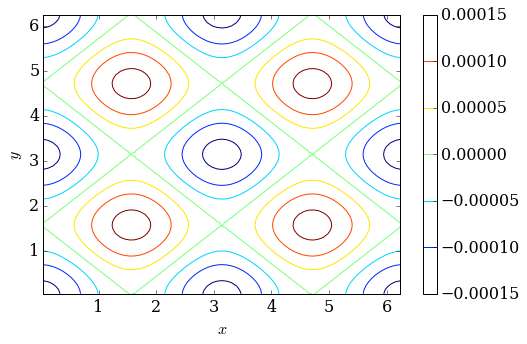

In [36]:
plot_2D(xc[2],yc[2],Ps[-1])

#pyplot.savefig('final_tgv_pressure.png')

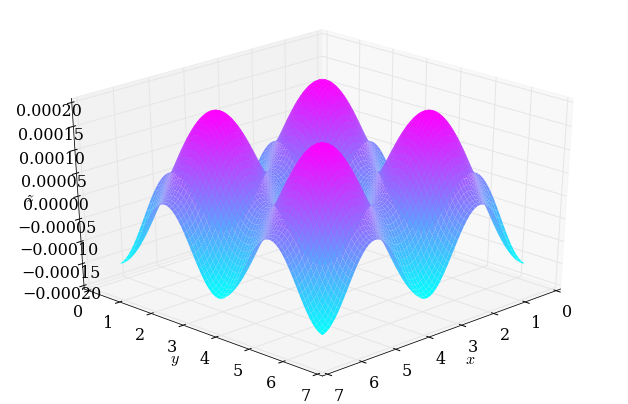

In [37]:
plot_3D(xc[2],xc[2],Ps[-1])
#pyplot.savefig('final_tgv_pressure_3d.png')

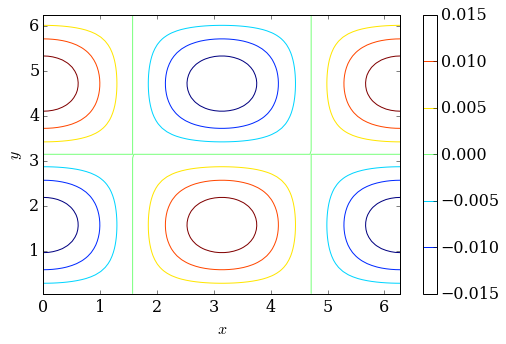

In [38]:
plot_2D(xb2[2],yb2[2],Us[-1])
#pyplot.savefig('final_tgv_u.png')

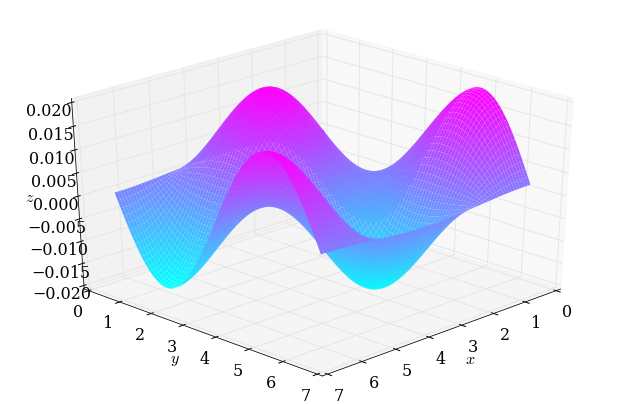

In [39]:
plot_3D(xb2[2],yb2[2],Us[-1])
#pyplot.savefig('final_tgv_u_3d.png')

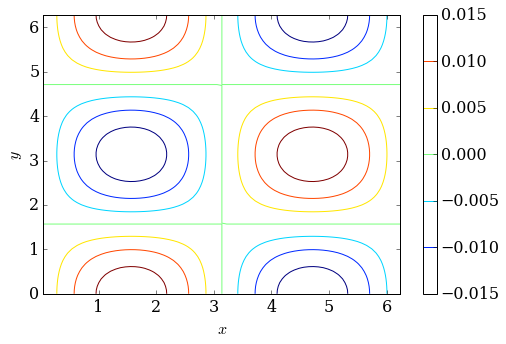

In [40]:
plot_2D(xb3[2],yb3[2],Vs[-1])
#pyplot.savefig('final_tgv_v.png')

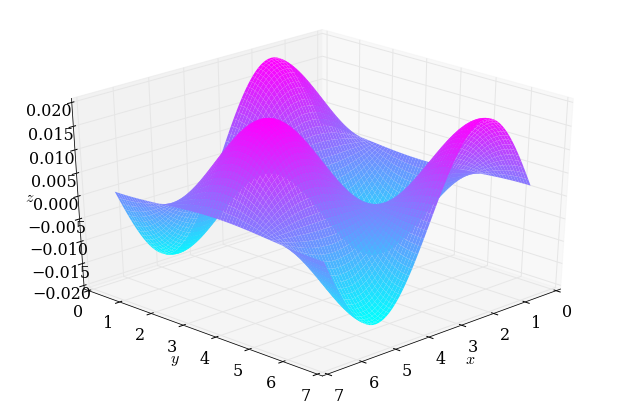

In [41]:
plot_3D(xb3[2],yb3[2],Vs[-1])
#pyplot.savefig('final_tgv_v_3d.png')

##### spatial accuracy

In [42]:
nx = [25, 50, 75, 100] 
p_err = [0.026821686365347135, 0.0075465675838813405,\
                     0.0039198733383037426,0.0026467758445123169 ]
u_err = [0.020791682177047788,0.0052472027755197269,\
        0.0023361800223051141,0.0013149073969569267]

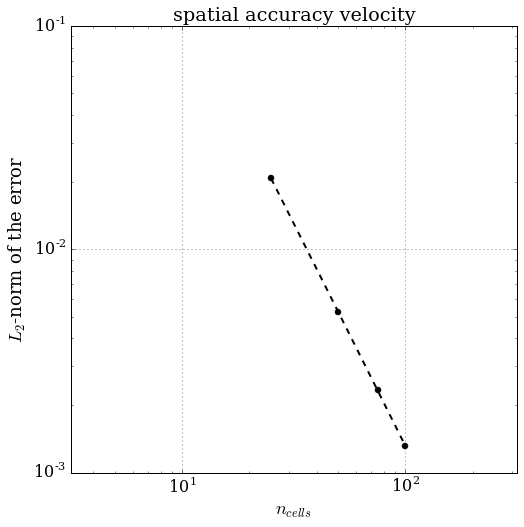

In [43]:
plot_error_grid_refine(u_err, nx, 'spatial accuracy velocity')
#pyplot.savefig('final_spatial_accuracy_velocity.png')

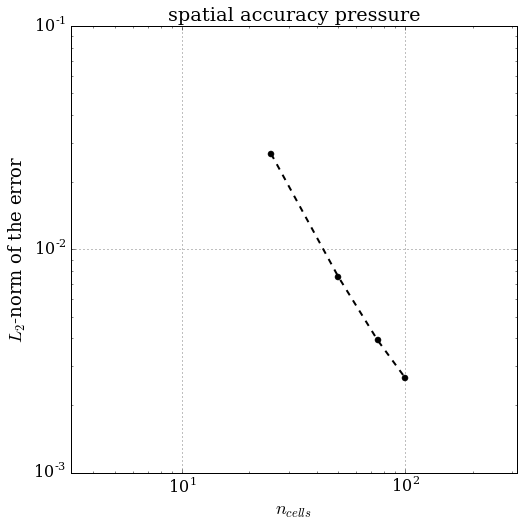

In [44]:
plot_error_grid_refine(p_err, nx, 'spatial accuracy pressure')
#pyplot.savefig('final_spatial_accuracy_pressure.png')

##### temporal accuracy

In [45]:
dtv = [0.0001,0.0005, 0.001,0.005]
perr = [0.0066497132057440301,0.0070501335092727204,\
        0.0075465675838813405, 0.011610612367450181 ]

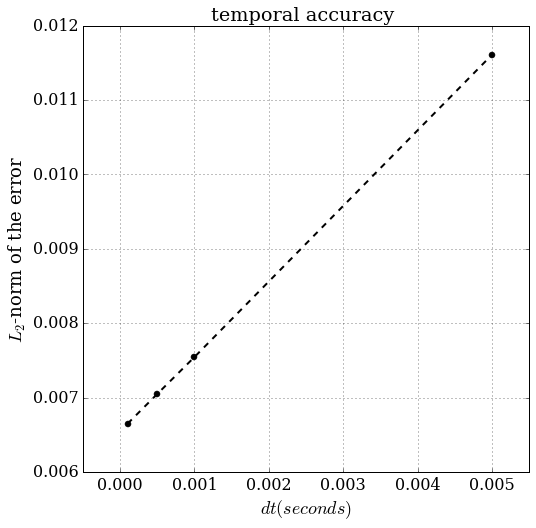

In [47]:
plot_error_time_refine(perr,dtv, 'temporal accuracy ')
#pyplot.savefig('final_temporal_accuracy.png')